# Main Insights

Revised research questions:
1. How do agency sample collection habits affect the number of HPAI cases detected?
    - Which agencies collect samples most frequently?
    - When do agencies collect samples most frequently (time of year)?
    - Where do agencies collect samples most frequently (geographic region)?
2. Is there an association between geographic region and season, and number of HPAI cases?
    - How do agency collection habits influence this association?
3. What is the forecast for the number of HPAI cases in the US over the next 3 months?

The goal of this notebook is to answer these questions through statistical analysis.

## Load Data

In [1]:
import pandas as pd

dataset_path = '../data/HPAI Detections in Wild Birds.csv'
hpai_data = pd.read_csv(dataset_path)
hpai_data.head(n=3)

,State,County,Collection Date,Date Detected,HPAI Strain,Bird Species,WOAH Classification,Sampling Method,Submitting Agency
0,North Dakota,Cass,9/12/2025,9/19/2025,EA H5,Canada goose,Wild bird,Morbidity/Mortality,ND Game and Fish
1,Pennsylvania,Bucks,9/8/2025,9/19/2025,EA H5,Black vulture,Wild bird,Morbidity/Mortality,PA Game Commission
2,Pennsylvania,Delaware,9/4/2025,9/19/2025,EA H5,Black vulture,Wild bird,Morbidity/Mortality,PA Game Commission


## Define Regions

We'll need to define regions for geographic analysis.

In [2]:
import us

region_map = {
    'Northeast': ['CT', 'ME', 'MA', 'NH', 'RI', 'VT', 'NJ', 'NY', 'PA'],
    'Midwest': ['IL', 'IN', 'MI', 'OH', 'WI', 'IA', 'KS', 'MN', 'MO', 'NE', 'ND', 'SD'],
    'South': ['DE', 'FL', 'GA', 'MD', 'NC', 'SC', 'VA', 'DC', 'WV', 'AL', 'KY', 'MS', 'TN', 'AR', 'LA', 'OK', 'TX'],
    'West': ['AZ', 'CO', 'ID', 'MT', 'NV', 'NM', 'UT', 'WY', 'AK', 'CA', 'HI', 'OR', 'WA']
}

state_to_region = {}
for region, states in region_map.items():
    for state in states:
        state_to_region[state] = region

df1 = hpai_data.copy()
df1['State'] = df1['State'].apply(lambda x: us.states.lookup(x).abbr if us.states.lookup(x) else x)
df1['Region'] = df1['State'].map(state_to_region)

df1.head(n=5)

,State,County,Collection Date,Date Detected,HPAI Strain,Bird Species,WOAH Classification,Sampling Method,Submitting Agency,Region
0,ND,Cass,9/12/2025,9/19/2025,EA H5,Canada goose,Wild bird,Morbidity/Mortality,ND Game and Fish,Midwest
1,PA,Bucks,9/8/2025,9/19/2025,EA H5,Black vulture,Wild bird,Morbidity/Mortality,PA Game Commission,Northeast
2,PA,Delaware,9/4/2025,9/19/2025,EA H5,Black vulture,Wild bird,Morbidity/Mortality,PA Game Commission,Northeast
3,NJ,Warren,9/11/2025,9/19/2025,EA H5,Black vulture,Wild bird,Morbidity/Mortality,NJ DEP,Northeast
4,NJ,Warren,9/11/2025,9/19/2025,EA H5,Black vulture,Wild bird,Morbidity/Mortality,NJ DEP,Northeast


## Define Seasons

We'll need to define seasons for temporal analysis. We use meteorological seasons:
- Winter: December, January, February
- Spring: March, April, May
- Summer: June, July, August
- Fall: September, October, November

In [3]:
seasons_map = {
    'Winter': ['Dec', 'Jan', 'Feb'],
    'Spring': ['Mar', 'Apr', 'May'],
    'Summer': ['Jun', 'Jul', 'Aug'],
    'Fall': ['Sep', 'Oct', 'Nov']
}

def parse_date(s):
    '''
    Attempts to parse a date string of format 'MM/DD/YYYY' to a datetime.

    If parsing fails, it returns pd.NaT (Not a Time).
    '''

    try:
        return pd.to_datetime(s, format='%m/%d/%Y', errors='coerce')
    except:
        return pd.NaT

month_to_season = {}
for season, months in seasons_map.items():
    for month in months:
        month_to_season[month] = season

df2 = df1.copy()

# convert date strings to datetime objects
# if parsing fails, the value will be set to pd.NaT because sometimes the date strings are invalid
df2['Date Detected'] = df2['Date Detected'].apply(parse_date)
df2['Collection Date'] = df2['Collection Date'].apply(parse_date)

# extract detection month and year
df2['Detection Month'] = pd.to_datetime(df2['Date Detected']).dt.strftime('%b')
df2['Detection Year'] = pd.to_datetime(df2['Date Detected']).dt.strftime('%Y')

# also extract collection month and year
df2['Collection Month'] = pd.to_datetime(df2['Collection Date']).dt.strftime('%b')
df2['Collection Year'] = pd.to_datetime(df2['Collection Date']).dt.strftime('%Y')

# map detection month to season
# use detection month because that's when the case is actually confirmed
df2['Season'] = df2['Detection Month'].map(month_to_season)

df2.head(n=1)

,State,County,Collection Date,Date Detected,HPAI Strain,Bird Species,WOAH Classification,Sampling Method,Submitting Agency,Region,Detection Month,Detection Year,Collection Month,Collection Year,Season
0,ND,Cass,2025-09-12,2025-09-19,EA H5,Canada goose,Wild bird,Morbidity/Mortality,ND Game and Fish,Midwest,Sep,2025,Sep,2025,Fall


## Question 1 - How do agency sample collection habits affect the number of HPAI cases detected?

Goal is to see if there's any bias in the data based on how often, when, and where agencies collect samples. Some agencies may collect more samples in a certain region because of proximity, or season because of staffing (among other reasons), which could skew the data. This may be important to consider when forecasting future cases across time and space.

Let's see which agencies collect the most samples. We'll look at the number of samples collected by each agency across each year and see if there's a pattern.

Collection Year,2022,2023,2024,2025,Total Samples,% of All Samples
Submitting Agency,,,,,,
NWDP,2939.0,1949.0,1950.0,916.0,7754.0,54.266
Private (non-government) submission,833.0,191.0,303.0,91.0,1418.0,9.924
SCWDS,256.0,90.0,65.0,4.0,415.0,2.904
CA DFW/CAHFS,218.0,113.0,72.0,40.0,443.0,3.100
NY DEC,159.0,66.0,77.0,145.0,447.0,3.128
MI DNR,145.0,14.0,6.0,81.0,246.0,1.722
UT DWR,112.0,33.0,5.0,1.0,151.0,1.057
FL FWCC,112.0,4.0,39.0,5.0,160.0,1.120
OR DFW,101.0,50.0,36.0,2.0,189.0,1.323


<Axes: title={'center': 'Samples Collected by Submitting Agency per Year'}, ylabel='Submitting Agency'>

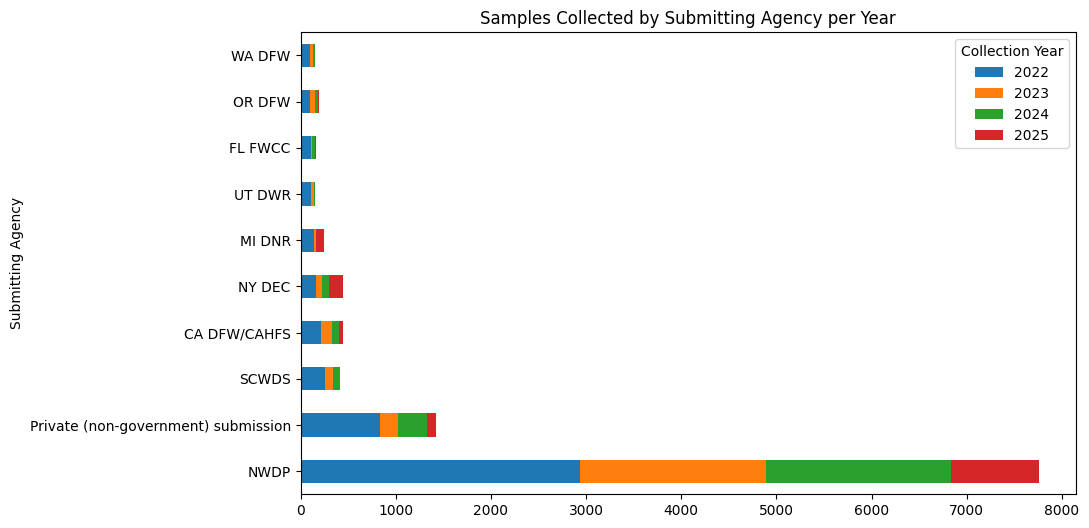

In [4]:
from IPython.display import display
df3 = df2.copy()
df3 = df3.loc[df3['Collection Year'].isin(['2022','2023','2024','2025'])]

df3 = df3.groupby(['Submitting Agency', 'Collection Year']).size().reset_index(name='Samples Collected').sort_values(by=['Samples Collected'], ascending=False)
df3_pivot = df3.pivot_table(index='Submitting Agency', columns='Collection Year', values='Samples Collected', fill_value=0).sort_values(by=['2022','2023','2024','2025'], ascending=False)

agency_totals = df3_pivot.sum(axis=1)
year_totals = df3_pivot.sum(axis=0)
df3_pivot['Total Samples'] = df3_pivot.sum(axis=1)
df3_pivot['% of All Samples'] = round(agency_totals / year_totals.sum() * 100.0, ndigits=3)

display(df3_pivot.head(n=10))
df3_pivot.head(n=10).drop(columns=['Total Samples', '% of All Samples']).plot.barh(stacked=True, figsize=(10, 6), title='Samples Collected by Submitting Agency per Year')

For the sake of brevity (there are 126 agencies), this is just the top 10.

The NWDP (National Wildlife Disease Program) is the agency that collects the most samples by far. See https://www.aphis.usda.gov/national-wildlife-programs/nwdp for more info on the NWDP. Private entities collect the next most samples.

Let's drill down into how many samples each agency collects during the seasons.

In [5]:
df4 = df2.copy()
df4 = df4.loc[df4['Collection Year'].isin(['2022','2023','2024','2025'])]

df4 = df4.groupby(['Submitting Agency', 'Collection Year', 'Season']).size().reset_index(name='Samples Collected').sort_values(by=['Samples Collected'], ascending=False)

df4_pivot = df4.pivot_table(index=['Submitting Agency', 'Season'], columns='Collection Year', values='Samples Collected', fill_value=0)

agency_totals = df4_pivot.sum(axis=1)
year_totals = df4_pivot.sum(axis=0)
df4_pivot['Total Samples'] = df4_pivot.sum(axis=1)
df4_pivot['% of Agency Samples'] = round(agency_totals / df3_pivot['Total Samples'] * 100.0, ndigits=3)
df4_pivot['% of All Samples'] = round(agency_totals / year_totals.sum() * 100.0, ndigits=3)

df4_pivot = df4_pivot.sort_values(by=['% of All Samples'], ascending=False)
df4_pivot.head(n=10)

Collection Year                               2022    2023    2024   2025  \
Submitting Agency                   Season                                  
NWDP                                Winter   785.0   511.0  1429.0  637.0   
                                    Fall    1449.0  1162.0   335.0   87.0   
                                    Spring   610.0    43.0    75.0  143.0   
Private (non-government) submission Spring   350.0    41.0   101.0   11.0   
NWDP                                Summer    95.0   233.0   111.0   49.0   
Private (non-government) submission Fall     236.0    58.0    35.0    3.0   
                                    Summer   101.0     7.0   127.0   65.0   
Tufts University                    Summer    64.0     0.0    18.0  209.0   
Private (non-government) submission Winter   146.0    85.0    40.0   12.0   
CA DFW/CAHFS                        Winter    94.0    58.0    33.0    0.0   

Collection Year                             Total Samples  \
Submitting Agency                   Season                  
NWDP                                Winter         3362.0   
                                    Fall           3033.0   
                                    Spring          871.0   
Private (non-government) submission Spring          503.0   
NWDP                                Summer          488.0   
Private (non-government) submission Fall            332.0   
                                    Summer          300.0   
Tufts University                    Summer          291.0   
Private (non-government) submission Winter          283.0   
CA DFW/CAHFS                        Winter          185.0   

Collection Year                             % of Agency Samples  \
Submitting Agency                   Season                        
NWDP                                Winter               43.358   
                                    Fall                 39.115   
                                    Spring               11.233   
Private (non-government) submission Spring               35.472   
NWDP                                Summer                6.294   
Private (non-government) submission Fall                 23.413   
                                    Summer               21.157   
Tufts University                    Summer               85.088   
Private (non-government) submission Winter               19.958   
CA DFW/CAHFS                        Winter               41.761   

Collection Year                             % of All Samples  
Submitting Agency                   Season                    
NWDP                                Winter            23.529  
                                    Fall              21.226  
                                    Spring             6.096  
Private (non-government) submission Spring             3.520  
NWDP                                Summer             3.415  
Private (non-government) submission Fall               2.323  
                                    Summer             2.100  
Tufts University                    Summer             2.037  
Private (non-government) submission Winter             1.981  
CA DFW/CAHFS                        Winter             1.295

Top 10 for sake of brevity.

Still notice that the NWDP collects the most samples. Interestingly, the number of samples collected by the NWDP seems to peak in the winter and fall seasons regardless of year. Overall, they collect the bulk of their samples in the fall and winter seasons, and account for a little over 50% of all samples collected.

Finally, let's look at where agencies collect the most samples.

In [6]:
from IPython.display import display

df5 = df2.copy()
df5 = df5.loc[df5['Collection Year'].isin(['2022','2023','2024','2025'])]
df5 = df5.groupby(['Submitting Agency', 'Collection Year', 'Region']).size().reset_index(name='Samples Collected').sort_values(by=['Samples Collected'], ascending=False)

df5_pivot = df5.pivot_table(index=['Submitting Agency', 'Region'], columns='Collection Year', values='Samples Collected', fill_value=0)

agency_totals = df5_pivot.sum(axis=1)
year_totals = df5_pivot.sum(axis=0)
df5_pivot['Total Samples'] = df5_pivot.sum(axis=1)
df5_pivot['% of Agency Samples'] = round(agency_totals / df3_pivot['Total Samples'] * 100.0, ndigits=3)
df5_pivot['% of All Samples'] = round(agency_totals / year_totals.sum() * 100.0, ndigits=3)

df5_pivot = df5_pivot.sort_values(by=['% of All Samples'], ascending=False)
display(df5_pivot.head(n=15))


Collection Year                                  2022   2023   2024   2025  \
Submitting Agency                   Region                                   
NWDP                                Midwest    1074.0  731.0  364.0  205.0   
                                    South       842.0  512.0  708.0  155.0   
                                    West        626.0  600.0  678.0  115.0   
                                    Northeast   397.0  106.0  200.0  441.0   
NY DEC                              Northeast   159.0   66.0   76.0  145.0   
CA DFW/CAHFS                        West        218.0  113.0   72.0   40.0   
Private (non-government) submission Midwest     333.0   27.0   48.0   24.0   
                                    South       271.0   34.0   81.0   23.0   
Tufts University                    Northeast    78.0   14.0   40.0  207.0   
Private (non-government) submission West        152.0   92.0   51.0   14.0   
                                    Northeast    77.0   38.0  123.0   30.0   
MI DNR                              Midwest     145.0   14.0    6.0   81.0   
SCWDS                               South       124.0   53.0   63.0    3.0   
PA Game Commission                  Northeast    74.0   26.0   13.0  122.0   
OR DFW                              West        101.0   50.0   36.0    2.0   

Collection Year                                Total Samples  \
Submitting Agency                   Region                     
NWDP                                Midwest           2374.0   
                                    South             2217.0   
                                    West              2019.0   
                                    Northeast         1144.0   
NY DEC                              Northeast          446.0   
CA DFW/CAHFS                        West               443.0   
Private (non-government) submission Midwest            432.0   
                                    South              409.0   
Tufts University                    Northeast          339.0   
Private (non-government) submission West               309.0   
                                    Northeast          268.0   
MI DNR                              Midwest            246.0   
SCWDS                               South              243.0   
PA Game Commission                  Northeast          235.0   
OR DFW                              West               189.0   

Collection Year                                % of Agency Samples  \
Submitting Agency                   Region                           
NWDP                                Midwest                 30.616   
                                    South                   28.592   
                                    West                    26.038   
                                    Northeast               14.754   
NY DEC                              Northeast               99.776   
CA DFW/CAHFS                        West                   100.000   
Private (non-government) submission Midwest                 30.465   
                                    South                   28.843   
Tufts University                    Northeast               99.123   
Private (non-government) submission West                    21.791   
                                    Northeast               18.900   
MI DNR                              Midwest                100.000   
SCWDS                               South                   58.554   
PA Game Commission                  Northeast              100.000   
OR DFW                              West                   100.000   

Collection Year                                % of All Samples  
Submitting Agency                   Region                       
NWDP                                Midwest              16.614  
                                    South                15.515  
                                    West                 14.130  
                                    Northeast             8.006

Some key observations from all of the above:
- NWDP generally collects the most samples across all years, seasons, and regions.
    - Largest percentage too (>50%)
- NWDP seems to collect samples most frequently in the winter and fall seasons.
- NWDP collects significantly fewer samples in the Northeast region but does collect a similar (higher) number of samples in the Midwest, South, and West regions.
    - 2025 is an exception in that the NWDP so far has collected more samples in the Northeast than any other region.

These observations suggest the following:
1. NWDP has the most impact on detections overall.
2. There may be seasonal bias in the data due to the NWDP's collection patterns.
3. There may be regional bias in the data due to the NWDP's smaller number of samples collected in the Northeast region.

Let's see if there's a significant association between Region and Submitting Agency.

In [7]:
from IPython.display import display
from scipy.stats import chi2_contingency
from scipy.stats.contingency import association

contingency_table = pd.crosstab(index=df2['Submitting Agency'], columns=df2['Region'])
display(contingency_table)

chi2, p, dof, expected = chi2_contingency(contingency_table)

print(f"Chi-Square Test: p-value = {p}\t degrees of freedom = {dof}")
if p < 0.05:
    print("Region and Submitting Agency are dependent.")
else:
    print("Region and Submitting Agency are independent.")


assoc = round(association(contingency_table, method='cramer'), ndigits=3)
print(f'Cramer\'s V association between Region and Submitting Agency: {assoc}')

Region,Midwest,Northeast,South,West
Submitting Agency,,,,
AK DFG,0,0,0,20
AK DFG/USFWS,0,0,0,99
AL DAI,0,0,1,0
AL DCNR,0,0,21,0
AL DCNR/NWDP,0,0,7,0
...,...,...,...,...
WI DNR/USGS,22,0,0,0
WV DNR/SCWDS,0,0,1,0
WY GFD,0,0,0,170


Chi-Square Test: p-value = 0.0	 degrees of freedom = 378
Region and Submitting Agency are dependent.
Cramer's V association between Region and Submitting Agency: 0.575


The independence test suggests that there is a significant association between Region and Submitting Agency (p < 0.05). This means that the distribution of submitting agencies varies by region (not randomly), which could introduce bias in the data. Since Cramér's V is 0.575 and we have 378 degrees of freedom, this indicates a strong association between Region and Submitting Agency. This further supports the idea that agency collection habits vary significantly by region, which could impact the analysis of HPAI cases.

We'll need to be mindful of this when analyzing HPAI cases across regions, and careful about generalizing findings since the data may reflect agency collection habits as much as actual HPAI prevalence/distribution.


## Question 2 - Is there an association between geographic region and season, and number of HPAI cases?

Goal is to assess how region and season relate to number of HPAI cases, if at all.

Let's see which regions have the most cases overall across all years.

Detection Year,2022,2023,2024,2025,Total Cases,% of All Cases
Region,,,,,,
Midwest,2039.0,859.0,567.0,637.0,4102.0,28.296
Northeast,800.0,273.0,471.0,1092.0,2636.0,18.183
South,1463.0,582.0,990.0,492.0,3527.0,24.329
West,1619.0,1083.0,1026.0,504.0,4232.0,29.192


<Axes: title={'center': 'HPAI Cases by Region and Year'}, ylabel='Region'>

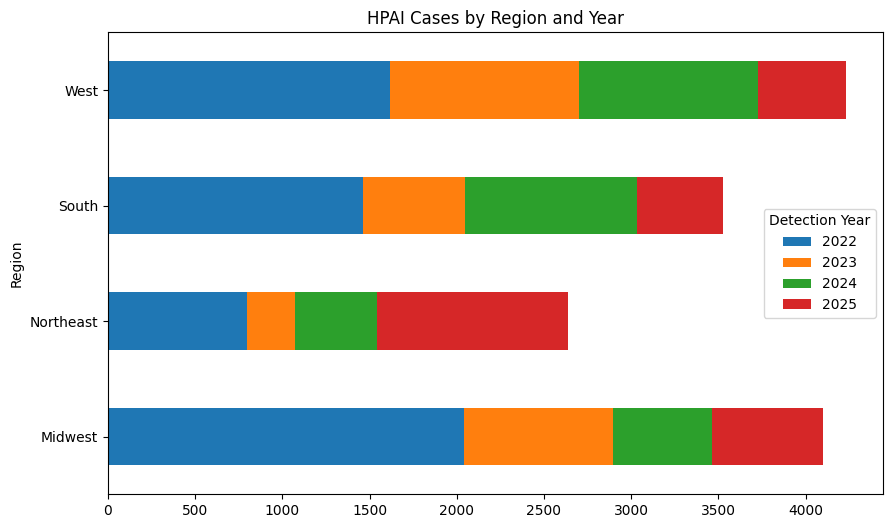

In [8]:
from IPython.display import display

df6 = df2.copy()
df6 = df6.groupby(['Region', 'Detection Year']).size().reset_index(name='HPAI Cases').sort_values(by=['HPAI Cases'], ascending=False)
df6_pivot = df6.pivot_table(index='Region', columns='Detection Year', values='HPAI Cases', fill_value=0)
region_totals = df6_pivot.sum(axis=1)
year_totals = df6_pivot.sum(axis=0)
df6_pivot['Total Cases'] = df6_pivot.sum(axis=1)
df6_pivot['% of All Cases'] = round(region_totals / year_totals.sum() * 100.0, ndigits=3)

display(df6_pivot)
df6_pivot.drop(columns=['Total Cases', '% of All Cases']).plot(kind='barh', stacked=True, figsize=(10, 6), title='HPAI Cases by Region and Year')

Recall previously that the NWDP collects the most samples overall, and specifically doesn't collect as many samples in the Northeast region. This may explain why the Northeast has the fewest cases overall by a significant margin.

Let's see how many cases each region has during the seasons. From our observations, we would expect the winter and fall seasons to have the most cases.

Detection Year      2022   2023   2024   2025  Total Cases  \
Region    Season                                             
Midwest   Fall     688.0  510.0  132.0   67.0       1397.0   
          Spring  1039.0   82.0   47.0   99.0       1267.0   
          Summer   137.0   14.0  143.0  290.0        584.0   
          Winter   175.0  253.0  245.0  181.0        854.0   
Northeast Fall     308.0   22.0   35.0   16.0        381.0   
          Spring   165.0   91.0  153.0   89.0        498.0   
          Summer   140.0    4.0  107.0  580.0        831.0   
          Winter   187.0  156.0  176.0  407.0        926.0   
South     Fall     586.0   48.0  333.0    5.0        972.0   
          Spring   209.0   71.0   50.0   48.0        378.0   
          Summer   119.0   40.0   72.0  162.0        393.0   
          Winter   549.0  423.0  535.0  277.0       1784.0   
West      Fall     894.0  458.0  345.0   35.0       1732.0   
          Spring   244.0  145.0   52.0   52.0        493.0   
          Summer   246.0   71.0  159.0  252.0        728.0   
          Winter   235.0  409.0  470.0  165.0       1279.0   

Detection Year    % of Regional Cases  % of All Cases  
Region    Season                                       
Midwest   Fall                 34.057           9.636  
          Spring               30.887           8.740  
          Summer               14.237           4.028  
          Winter               20.819           5.891  
Northeast Fall                 14.454           2.628  
          Spring               18.892           3.435  
          Summer               31.525           5.732  
          Winter               35.129           6.388  
South     Fall                 27.559           6.705  
          Spring               10.717           2.607  
          Summer               11.143           2.711  
          Winter               50.581          12.306  
West      Fall                 40.926          11.947  
          Spring               11.649           3.401  
          Summer               17.202           5.022  
          Winter               30.222           8.823

<Axes: title={'center': 'HPAI Cases by Region, Season, and Year'}, ylabel='Region,Season'>

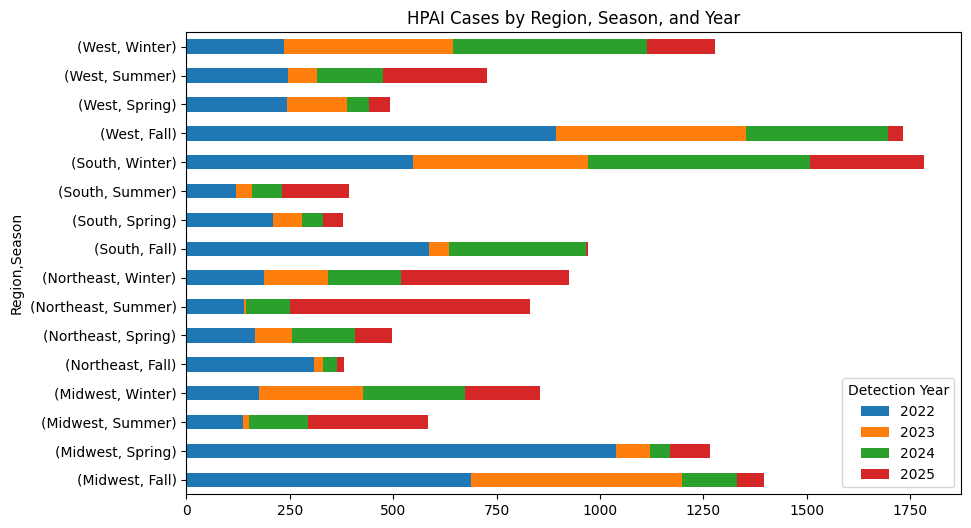

In [9]:
from IPython.display import display

df7 = df2.copy()
df7 = df7.loc[df7['Detection Year'].isin(['2022','2023','2024','2025'])]

df7 = df7.groupby(['Region', 'Detection Year', 'Season']).size().reset_index(name='HPAI Cases').sort_values(by=['HPAI Cases'], ascending=False)
df7_pivot = df7.pivot_table(index=['Region', 'Season'], columns='Detection Year', values='HPAI Cases', fill_value=0)

region_and_season_totals = df7_pivot.sum(axis=1)
year_totals = df7_pivot.sum(axis=0)
df7_pivot['Total Cases'] = region_and_season_totals
df7_pivot['% of Regional Cases'] = round(df7_pivot['Total Cases'] / df6_pivot['Total Cases'] * 100.0, ndigits=3)
df7_pivot['% of All Cases'] = round(region_and_season_totals / year_totals.sum() * 100.0, ndigits=3)

display(df7_pivot)
df7_pivot.drop(columns=['Total Cases', '% of Regional Cases', '% of All Cases']).plot(kind='barh', stacked=True, figsize=(10, 6), title='HPAI Cases by Region, Season, and Year')

Some observations:
- In the Midwest, most cases were detected in the fall and spring seasons.
- In the Northeast, most cases were detected in the summer and winter.
- In the South, most cases were detected in the fall and winter.
- In the West, most cases were detected in the fall and winter.

As expected, the Northeast has the smallest percentage of cases by a significant margin. This aligns with our earlier observations about the NWDP's collection patterns, which indicated a lower focus on this region. The NWDP is much more active in the other regions, which may help explain why those regions have a higher percentage of cases, among other factors.

It's important to note that there was an outbreak of HPAI in 2022, specifically in a commercial flock in Indiana, which is in the Midwest region. This outbreak likely contributed to the higher number of cases observed in the Midwest during that year. See https://www.congress.gov/crs-product/R48518 for more information on the initial outbreak.

Let's see if there's a significant association between Region and Season.


In [10]:
from IPython.display import display
from scipy.stats import chi2_contingency
from scipy.stats.contingency import association

df8 = df2.copy()
df8 = df8.loc[df8['Detection Year'].isin(['2022','2023','2024','2025'])]

contingency_table = pd.crosstab(index=df8['Region'], columns=df8['Season'])
display(contingency_table)

chi2, p, dof, expected = chi2_contingency(contingency_table)

print(f"Chi-Square Test: p-value = {p}\t degrees of freedom = {dof}")
if p < 0.05:
    print("Region and Season are dependent.")
else:
    print("Region and Season are independent.")


assoc = round(association(contingency_table, method='cramer'), ndigits=3)
print(f'Cramer\'s V association between Region and Season: {assoc}') # see https://www.statology.org/interpret-cramers-v/ for interpreting Cramér's V

Season,Fall,Spring,Summer,Winter
Region,,,,
Midwest,1397,1267,584,854
Northeast,381,498,831,926
South,972,378,393,1784
West,1732,493,728,1279


Chi-Square Test: p-value = 0.0	 degrees of freedom = 9
Region and Season are dependent.
Cramer's V association between Region and Season: 0.209


This indicates that there is a significant association between Region and Season (p < 0.05). This suggests that the distribution of HPAI cases varies by both region and season (not randomly), which could be influenced by factors such as seasonal migratory patterns of wild birds, environmental conditions, and also agency collection habits, among other things.

Let's also look at the association between Season and Submitting Agency to see if agency collection habits vary by season as well.

In [11]:
from IPython.display import display
from scipy.stats import chi2_contingency
from scipy.stats.contingency import association

df9 = df2.copy()
df9 = df9.loc[df9['Detection Year'].isin(['2022','2023','2024','2025'])]

contingency_table = pd.crosstab(index=df9['Season'], columns=df9['Submitting Agency'])
display(contingency_table)

chi2, p, dof, expected = chi2_contingency(contingency_table)

print(f"Chi-Square Test: p-value = {p}\t degrees of freedom = {dof}")
if p < 0.05:
    print("Season and Submitting Agency are dependent.")
else:
    print("Season and Submitting Agency are independent.")

assoc = round(association(contingency_table, method='cramer'), ndigits=3)
print(f'Cramer\'s V association between Season and Submitting Agency: {assoc}')

Submitting Agency,AK DFG,AK DFG/USFWS,AL DAI,AL DCNR,AL DCNR/NWDP,APHIS Wildlife Services,AR Dept of Ag,AR GFC,AR GFC/SCWDS,AZ GFD,...,WA DFW,WA DFW/USGS,WA GFD,WI DNR,WI DNR/USFWS/USGS,WI DNR/USGS,WV DNR/SCWDS,WY GFD,WY State Veterinary Lab,Washington State University
Season,,,,,,,,,,,,,,,,,,,,,
Fall,13,12,0,7,0,0,1,1,0,3,...,40,3,1,3,0,3,0,45,0,0
Spring,2,25,0,5,0,0,0,1,0,4,...,30,0,0,5,1,13,0,65,0,0
Summer,2,51,0,0,7,4,0,4,2,1,...,54,1,0,4,0,6,0,20,14,1
Winter,3,11,1,9,0,22,1,4,23,3,...,27,4,0,0,0,0,1,40,0,0


Chi-Square Test: p-value = 0.0	 degrees of freedom = 378
Season and Submitting Agency are dependent.
Cramer's V association between Season and Submitting Agency: 0.371


So far, we've observed the following variable associations:
- Strong association between Region and Submitting Agency.
- Moderate association between Region and Season.
- Strong association between Season and Submitting Agency.

Region and Season make sense to be moderately associated since migratory patterns of wild birds vary by both region and season - we expect some seasonality. 

The strong associations involving Submitting Agency suggest that agency collection habits vary significantly by both region and season, which could be problematic when analyzing HPAI cases since the data may reflect agency collection habits as much as actual HPAI prevalence/distribution. That's something we'll need to account for when forecasting future cases.

## Question 3 - What is the forecast for the number of HPAI cases in over the next 4 months?

Goal is to build a model to forecast number of HPAI cases in each region over the next 4 months. We'll need to account for agency collection habits and their impact on case detection, as well as associations between region, season, and number of cases.

We'll use a SARIMAX model for this, since it can handle seasonality and exogenous variables (like agency collection frequency and region).

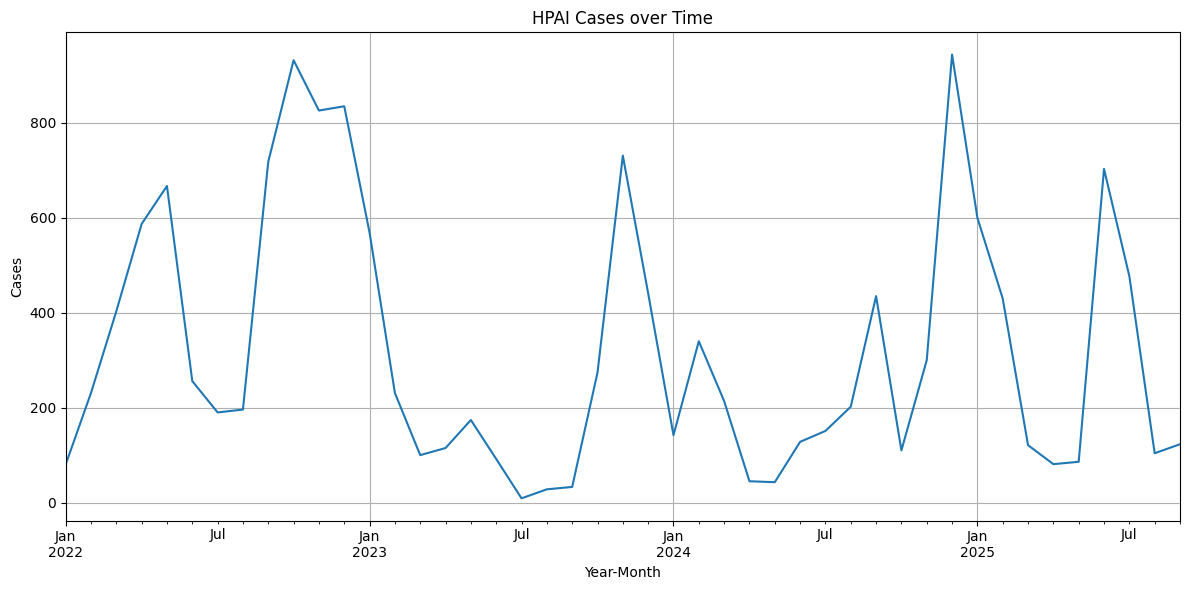

Latest date in dataset: 2025-09-19 00:00:00


In [12]:
import matplotlib.pyplot as plt

forecast_df = df2.copy()
forecast_df['Detection Year-Month'] = forecast_df['Date Detected'].dt.to_period('M')

plt.figure(figsize=(12,6))
forecast_df.groupby('Detection Year-Month').size().plot()
plt.title('HPAI Cases over Time')
plt.xlabel('Year-Month')
plt.ylabel('Cases')
plt.grid(True)
plt.tight_layout()
plt.show()

latest_date = df2['Date Detected'].max()
print(f'Latest date in dataset: {latest_date}')


In [13]:
forecast_df = df2.copy()
forecast_df['Detection Year-Month'] = forecast_df['Date Detected'].dt.to_period('M')

us_cases = forecast_df.groupby('Detection Year-Month').size()
us_cases.index = us_cases.index.to_timestamp() # have to convert for models to work

# check for stationarity with ADF test
from statsmodels.tsa.stattools import adfuller

adf_result = adfuller(us_cases)
print(f'ADF Statistic: {adf_result[0]}')
print(f'p-value: {adf_result[1]}')
for key, value in adf_result[4].items():
    print(f'Critical Value {key}: {value}')

if adf_result[1] < 0.05:
    print("The time series is stationary.")
else:
    print("The time series is not stationary.")

ADF Statistic: -4.142488315216198
p-value: 0.0008232244288815873
Critical Value 1%: -3.5925042342183704
Critical Value 5%: -2.931549768951162
Critical Value 10%: -2.60406594375338
The time series is stationary.


One of the assumptions is that the data is stationary. We can check this using the Augmented Dickey-Fuller test. If the p-value is less than 0.05, we can reject the null hypothesis that the data is non-stationary. From the above, we can see that the p-value is less than 0.05, so we can reject the null hypothesis and conclude that the data is stationary!

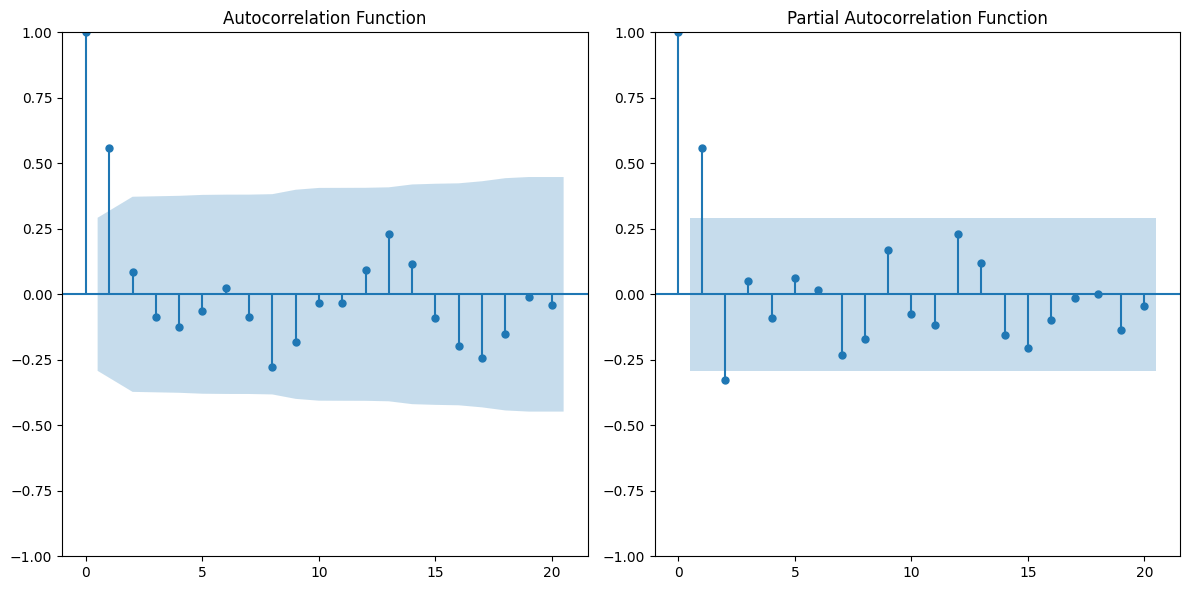

In [14]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt

# Plot ACF and PACF
plt.figure(figsize=(12, 6))
plt.subplot(121)
plot_acf(us_cases, lags=20, ax=plt.gca())
plt.title('Autocorrelation Function')

plt.subplot(122)
plot_pacf(us_cases, lags=20, ax=plt.gca())
plt.title('Partial Autocorrelation Function')

plt.tight_layout()
plt.show()

In [64]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

model = SARIMAX(
    us_cases,
    order=(3, 0, 2), # non-seasonal parameters (p, d, q)
    seasonal_order=(1, 1, 1, 12) # seasonal parameters (P, D, Q, s)
)
results = model.fit()
results.summary()

/home/noahg/.pyenv/versions/math316/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/noahg/.pyenv/versions/math316/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/noahg/.pyenv/versions/math316/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/home/noahg/.pyenv/versions/math316/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed 

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                    y   No. Observations:                   45
Model:             SARIMAX(3, 0, 2)x(1, 1, [1], 12)   Log Likelihood                -225.275
Date:                              Fri, 17 Oct 2025   AIC                            466.551
Time:                                      19:02:39   BIC                            478.523
Sample:                                  01-01-2022   HQIC                           470.579
                                       - 09-01-2025                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.7436      0.319      5.466      0.000       1.118       2.369
ar.L2         -1.6292      0.588     -2.773      0.006      -2.781      -0.478
ar.L3          0.7089      0.460      1.541      0.123      -0.193       1.611
ma.L1         -1.3253      0.238     -5.571      0.000      -1.792      -0.859
ma.L2          0.8710      0.273      3.187      0.001       0.335       1.407
ar.S.L12      -0.4903      1.232     -0.398      0.691      -2.904       1.924
ma.S.L12      -0.1684      1.881     -0.090      0.929      -3.855       3.518
sigma2       5.87e+04   3.11e+04      1.886      0.059   -2292.940     1.2e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 0.91
Prob(Q):                              0.97   Prob(JB):                         0.63
Heteroskedasticity (H):               0.99   Skew:                             0.41
Prob(H) (two-sided):                  0.99   Kurtosis:                         3.03
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

2025-10-01    266.006513
2025-11-01    741.272496
2025-12-01    856.965803
2026-01-01    442.628478
2026-02-01    312.509389
2026-03-01     67.160037
2026-04-01     35.239986
2026-05-01    157.173649
2026-06-01    441.845761
2026-07-01    304.887726
2026-08-01    109.341894
2026-09-01    215.237643
Freq: MS, Name: predicted_mean, dtype: float64


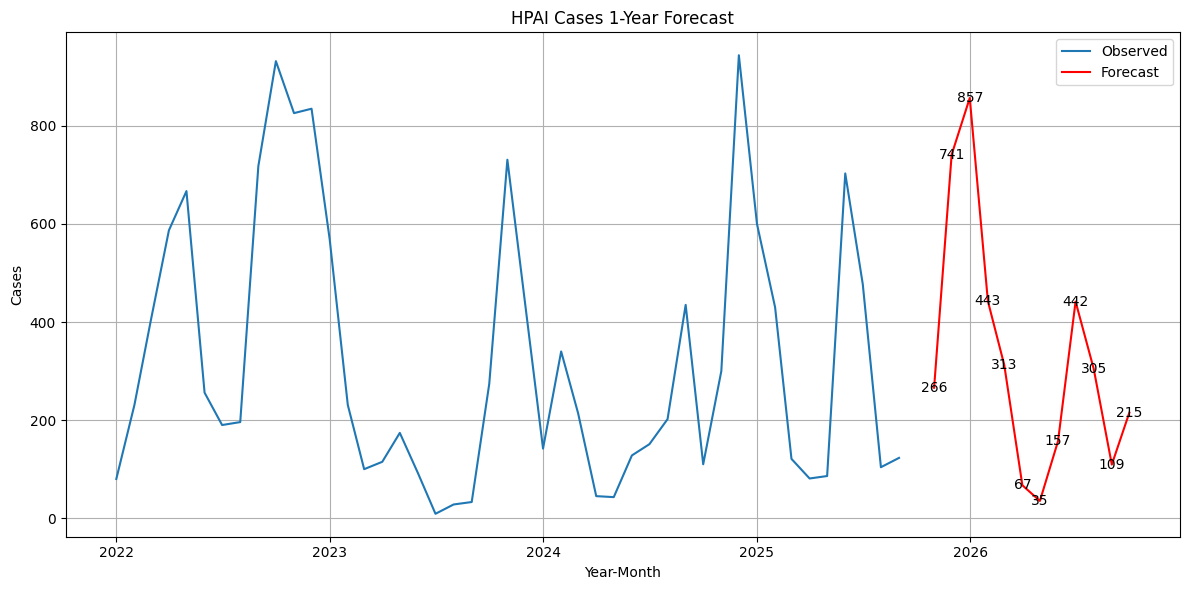

In [65]:
import matplotlib.pyplot as plt

forecast = results.get_forecast(steps=12) # forecast 12 months ahead
forecast_index = pd.date_range(start=us_cases.index[-1], periods=13, freq='ME')[1:] # adjust range for 12 months
forecast_values = forecast.predicted_mean
forecast_ci = forecast.conf_int()

print(forecast_values)

plt.figure(figsize=(12, 6))
plt.plot(us_cases, label='Observed')
plt.plot(forecast_index, forecast_values, label='Forecast', color='red')
for x, y in zip(forecast_index, forecast_values):
    plt.text(x, y, f'{y:.0f}', color='black', fontsize=10, ha='center', va='center')
plt.title('HPAI Cases 1-Year Forecast')
plt.xlabel('Year-Month')
plt.ylabel('Cases')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()